In [174]:
import sys
import codecs
import nltk
import csv
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from datetime import datetime
import json
import pandas as pd
from elasticsearch import Elasticsearch
nltk.download('punkt')
nltk.download('stopwords')
import collections
import csv, json
from elasticsearch import Elasticsearch

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed
[nltk_data]     (_ssl.c:777)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed
[nltk_data]     (_ssl.c:777)>


In [175]:
def mergeNumDicts(Dict1, Dict2):
    #merging numerical values of dictionaries
    for item in Dict1:
        if item in Dict2:
            Dict2[item]+=Dict1[item]
        else:
            Dict2[item]=Dict1[item]
    #return merged dictionary
    return Dict2

In [176]:
def ValueCountDict(Dict):
        count=0
        for item in Dict:
            if not Dict[item]==0:
               count=count+1
        return count

In [177]:
def wordInDict(word,dict):
    if word in dict:
        dict[word]+=1
    else:
        dict[word]=1
    return dict

In [178]:
def WordCount(input_text, WordCount):

    # NLTK's default English stopwords
    default_stopwords = set(stopwords.words('english'))

    #print(default_stopwords)
    # We're adding some on our own - could be done inline like this...
    # custom_stopwords = set((u'–', u'dass', u'mehr'))
    # ... but let's read them from a file instead (one stopword per line, UTF-8)
    #stopwords_file = './stopwords.txt'
    #custom_stopwords = set(codecs.open(stopwords_file, 'r', 'utf-8').read().splitlines())
    custom_stopwords=[]
    custom_stopwords.append("'s")
    custom_stopwords=set(custom_stopwords)
    all_stopwords = default_stopwords | custom_stopwords

    #input_file = sys.argv[1]

    # fp = codecs.open(input_text, 'r', 'utf-8')

    words = word_tokenize(input_text)

    # Remove single-character tokens (mostly punctuation)
    words = [word for word in words if len(word) > 1]

    # Remove numbers
    words = [word for word in words if not word.isnumeric()]

    # Lowercase all words (default_stopwords are lowercase too)
    words = [word.lower() for word in words]

    # Stemming words seems to make matters worse, disabled
    #stemmer = nltk.stem.snowball.SnowballStemmer('english')
    #words = [stemmer.stem(word) for word in words]

    # Remove stopwords
    words = [word for word in words if word not in all_stopwords]
    # Calculate frequency distribution
    for word in words:
        WordCount= wordInDict(word, WordCount)

    return WordCount

In [179]:
def itemnotInDict(item,Dict):
    if not item in Dict:
        Dict[item]=0
    return Dict

In [180]:
es = Elasticsearch()

In [181]:
csvfile = "/Users/panagiotismavridis/Downloads/15k_transcripts.csv"
metadatafile = pd.read_csv(csvfile, sep=',', encoding='utf-8',low_memory=False)
testing=metadatafile

In [182]:
AlJaz={}
BBC={}
CNN={}
RT={}
DW={}
F24={}
SP={}
AllChannels={}

In [183]:
print("Processing videos")
for rows in testing.iterrows():
      videoid = rows[1]['display_id']
      uploader= rows[1]['uploader']
      #date=rows[1]['upload_date']
      #if not validateDate(date):
      #  date=date_transformlambda(str(int(date)))
      # json_dict={}
      # json_dict['display_id']=videoid
      # json_dict['uploader']= uploader
      # json_dict['date']=date
      text= rows[1]['clean_text']
      if uploader == "RT":
        #print("mpika RT")
        RT=WordCount(text,RT)
      elif uploader == "Al Jazeera English":
        #print("mpika Al")
        AlJaz=WordCount(text,AlJaz)
      elif uploader == "DW English":
        #print("mpika DW")
        DW=WordCount(text,DW)
      elif uploader == "CNN":
        #print("mpika CNN")
        CNN=WordCount(text,CNN)
      elif uploader == "Sputnik":
        #print("mpika Sputnik")
        SP=WordCount(text,SP)
      elif uploader == "FRANCE 24 English":
        #print("mpika France")
        F24=WordCount(text,F24)
      else:
        #print("mpika BBC")
        BBC=WordCount(text,BBC)

Processing videos


In [184]:
#AllChannels=mergeNumDicts(BBC, AllChannels)
#AllChannels=mergeNumDicts(F24, AllChannels)
#AllChannels=mergeNumDicts(SP, AllChannels)
CNNitems=len(CNN.keys())
DWitems=len(DW.keys())
AlJazitems=len(AlJaz.keys())
RTitems=len(RT.keys())
AllChannels=mergeNumDicts(CNN, AllChannels)
AllChannels=mergeNumDicts(DW, AllChannels)
AllChannels=mergeNumDicts(AlJaz, AllChannels)
AllChannels=mergeNumDicts(RT, AllChannels)

In [185]:
Accudf=pd.DataFrame(columns=["word", "RT", "CNN", "AlJazeera", "DW"]) 

for item in AllChannels:
    RT=itemnotInDict(item,RT)
    CNN=itemnotInDict(item,CNN)
    AlJaz=itemnotInDict(item,AlJaz)
    F24=itemnotInDict(item,F24)
    SP=itemnotInDict(item,SP)
    DW=itemnotInDict(item,DW)
    BBC=itemnotInDict(item,BBC)
    All=AllChannels[item]
    Channels=[]

    Channels.append(All)
    Channels.append(RT[item])
    Channels.append(CNN[item])
    Channels.append(AlJaz[item])
    #Channels.append(F24[item])
    #Channels.append(SP[item])
    Channels.append(DW[item])
    #Channels.append(BBC[item])

    Accudoc={"word": item, "RT": RT[item]/All, "CNN": CNN[item]/All, "AlJazeera": AlJaz[item]/All,"DW": DW[item]/All}
    Accudf= Accudf.append(Accudoc, ignore_index=True)
Accudf.to_csv("WordCountAccuracy.csv", sep=';', encoding='utf-8', index=False)

In [186]:
#Accuracy matrix for each channel
print(Accudf)

                        word        RT       CNN  AlJazeera        DW
0                    sheheen  0.000000  1.000000   0.000000  0.000000
1                      thank  0.309124  0.090632   0.525023  0.075221
2                       much  0.263170  0.067475   0.528545  0.140810
3                       kind  0.280768  0.067674   0.527856  0.123702
4                    remarks  0.274074  0.222222   0.414815  0.088889
5                        let  0.285970  0.102794   0.509688  0.101549
6                      begin  0.224377  0.096953   0.542936  0.135734
7                   thanking  0.250000  0.194444   0.500000  0.055556
8                    million  0.224385  0.071107   0.572336  0.132172
9                  americans  0.348585  0.121900   0.485854  0.043660
10                     voted  0.255441  0.153494   0.516609  0.074456
11                democratic  0.233076  0.136302   0.546115  0.084507
12                 primaries  0.142857  0.214286   0.628571  0.014286
13                  

In [187]:
def Bayes(S1, S2, Sc1,Sc2):
    return ((S1 + 1)*(Sc2))/((Sc1)*(S2+2))

In [188]:
#calculating the K-Bayes
Bayesdf=pd.DataFrame(columns=["word", "RT-CNN", "RT-AlJaz", "RT-DW", "CNN-AlJaz", "CNN-DW", "AlJaz-DW"]) 
for item in AllChannels:
    rt=RT[item]
    cnn=CNN[item]
    alj=AlJaz[item]
    dw=DW[item]
    
    Bayesdoc={"word": item, "RT-CNN": Bayes(RT[item],CNN[item],RTitems, CNNitems), "RT-AlJaz": Bayes(RT[item],AlJaz[item],RTitems, AlJazitems), "RT-DW": Bayes(RT[item],DW[item],RTitems, DWitems), "CNN-AlJaz": Bayes(CNN[item],AlJaz[item],CNNitems, AlJazitems),"CNN-DW": Bayes(CNN[item],DW[item],CNNitems, DWitems), "AlJaz-DW": Bayes(AlJaz[item],DW[item],AlJazitems, DWitems)}
    Bayesdf= Bayesdf.append(Bayesdoc, ignore_index=True)
Bayesdf.to_csv("WordCountBayes.csv", sep=';', encoding='utf-8', index=False)

In [189]:
print(Bayesdf)

                        word    RT-CNN  RT-AlJaz     RT-DW  CNN-AlJaz  \
0                    sheheen  0.301171  0.739581  0.485083   1.637125   
1                      thank  3.072852  0.870829  3.972778   0.282919   
2                       much  3.518657  0.736497  1.812120   0.209132   
3                       kind  3.738335  0.786751  2.199096   0.210130   
4                    remarks  1.072921  0.969107  2.633306   0.875015   
5                        let  2.510440  0.829884  2.728636   0.330323   
6                      begin  2.060346  0.611722  1.588727   0.294128   
7                   thanking  1.003903  0.739581  2.425413   0.654850   
8                    million  2.837391  0.580022  1.643433   0.203835   
9                  americans  2.571535  1.060792  7.631457   0.411338   
10                     voted  1.488138  0.731418  3.243538   0.487885   
11                democratic  1.537766  0.631470  2.652473   0.409281   
12                 primaries  0.584626  0.353713  3

In [190]:
#top20 mentioned words for RT-CNN (RT sorted)
top20wordRTCNN=Bayesdf
top20wordRTCNN=top20wordRTCNN.sort_values('RT-CNN', ascending=False).head(20)

In [191]:
print(top20wordRTCNN[['word','RT-CNN']])

             word      RT-CNN
76730     bitcoin  282.347626
96219      keiser  243.496593
23409         gon  198.998607
109774  crosstalk  173.474382
49906     ossetia  140.947935
56776    georgian  137.785642
38736         max  131.159884
60679       artis  125.136468
41170      greece  115.197832
40870      kaiser  113.541392
96034       stacy  111.132026
48031   austerity  110.680270
53120     gaddafi  107.066220
72        percent  104.506268
10645      soviet   96.675827
68304       artie   86.285435
36937     bankers   84.478410
44961       spain   82.219629
48052    eurozone   81.316116
48034       fifty   80.864360


In [192]:
#bottom20 mentioned words for RT-CNN (CNN sorted)
top20wordRTCNN=Bayesdf
top20wordRTCNN=top20wordRTCNN.sort_values('RT-CNN', ascending=True).head(20)
print(top20wordRTCNN[['word','RT-CNN']])

            word    RT-CNN
1313          ''  0.001931
1311          ``  0.004084
1576     e-mails  0.007722
3098          ts  0.013485
3367          t.  0.015314
7497        d.c.  0.015314
8160          w.  0.015851
22402    trayvon  0.016134
3147          te  0.016629
17495        nfl  0.018439
135           --  0.018489
3570          tr  0.019224
26138   bergdahl  0.019642
4208          tn  0.020078
3241          th  0.020190
3351          ou  0.023167
29976  hernandez  0.023777
4540          s.  0.023777
25860        cdc  0.025098
4426         tth  0.025815


In [193]:
#top20 RT-AlJaz words (RT sorted)
top20wordRTAlJAZ=Bayesdf
top20wordRTAlJAZ=top20wordRTAlJAZ.sort_values('RT-AlJaz', ascending=False).head(20)

In [194]:
print(top20wordRTAlJAZ[['word','RT-AlJaz']])

                       word    RT-AlJaz
109774            crosstalk  189.332831
60679                 artis  136.576027
96034                 stacy  121.291345
96219                keiser  113.895531
40870                kaiser   79.663479
121212                dimon   73.958137
3413                     rt   52.320099
84550                 ponzi   37.225596
122438            banksters   33.281162
114381             abkhazia   33.133245
22808                   cis   30.322836
73008        high-frequency   30.322836
121238  military-industrial   28.104092
121542             rickards   28.104092
102087            blankfein   27.611038
124072            collymore   27.364511
126535               maupin   27.364511
68304                 artie   25.683644
122908                  rbs   23.666604
62159                  arty   22.927023


In [195]:
#bottom20 mentioned words of RT-AlJaz (Al Jaz sorted)
top20wordRTAlJAZ=Bayesdf
top20wordRTAlJAZ=top20wordRTAlJAZ.sort_values('RT-AlJaz', ascending=True).head(20)
print(top20wordRTAlJAZ[['word','RT-AlJaz']])

                word  RT-AlJaz
9937         myanmar  0.003056
80824  aljazeera.com  0.003773
23943            anc  0.005208
15097        jazeera  0.005865
12216             aj  0.006321
30827         uganda  0.006403
56128     al-jazeera  0.008373
82075         dotnet  0.008831
50204      ethiopian  0.009019
55046          tamil  0.012642
21391            drc  0.012751
84754            m23  0.013447
51821         malika  0.013889
34146          kuala  0.015249
78563        somalis  0.016620
53445         hariri  0.016809
34147         lumpur  0.017609
38828       reynolds  0.017609
90731       khartoum  0.017821
71049        barnaby  0.018724


In [196]:
top20wordRTDW=Bayesdf
top20wordRTDW=top20wordRTAlJAZ.sort_values('RT-DW', ascending=False).head(20)

In [197]:
#top20 RT-DW terms RT sorted
print(top20wordRTDW[['word','RT-DW']])

                word     RT-DW
15097        jazeera  3.557273
56128     al-jazeera  2.182872
12216             aj  0.970165
82075         dotnet  0.970165
21391            drc  0.485083
23943            anc  0.485083
90731       khartoum  0.485083
80824  aljazeera.com  0.485083
84754            m23  0.485083
38828       reynolds  0.323388
34147         lumpur  0.323388
51821         malika  0.323388
53445         hariri  0.323388
78563        somalis  0.242541
71049        barnaby  0.194033
34146          kuala  0.138595
55046          tamil  0.138595
50204      ethiopian  0.064678
9937         myanmar  0.044098
30827         uganda  0.031296


In [198]:
#bottom 20 words of RT-DW (DW sorted)
top20wordRTDW=Bayesdf
top20wordRTDW=top20wordRTAlJAZ.sort_values('RT-DW', ascending=True).head(20)
print(top20wordRTDW[['word','RT-DW']])

                word     RT-DW
30827         uganda  0.031296
9937         myanmar  0.044098
50204      ethiopian  0.064678
34146          kuala  0.138595
55046          tamil  0.138595
71049        barnaby  0.194033
78563        somalis  0.242541
51821         malika  0.323388
53445         hariri  0.323388
34147         lumpur  0.323388
38828       reynolds  0.323388
23943            anc  0.485083
90731       khartoum  0.485083
21391            drc  0.485083
84754            m23  0.485083
80824  aljazeera.com  0.485083
82075         dotnet  0.970165
12216             aj  0.970165
56128     al-jazeera  2.182872
15097        jazeera  3.557273


In [199]:
top20wordCNNALJAZ=Bayesdf
top20wordCNNALJAZ=top20wordCNNALJAZ.sort_values('CNN-AlJaz', ascending=False).head(20)

In [200]:
#top20 words CNN-AlJaz (CNN sorted)
print(top20wordCNNALJAZ[['word','CNN-AlJaz']])

            word  CNN-AlJaz
1576     e-mails  94.953250
10738     e-mail  54.570833
135           --  53.028614
7497        d.c.  47.476625
3367          t.  47.476625
8160          w.  45.839500
1313          ''  40.281891
10574        jeb  35.812109
8209      tapper  31.923938
1311          ``  30.791883
4540          s.  30.286812
3363          ea  28.922542
4426         tth  27.831125
37494  sharknado  27.012563
3241          th  26.491659
7196   kellyanne  26.194000
7087     priebus  25.375438
3570          tr  25.102583
26219        v.a  24.556875
6725         tha  23.738312


In [201]:
#bottom 20 words CNN -AlJaz (Aljaz sorted)
top20wordCNNALJAZ=Bayesdf
top20wordCNNALJAZ=top20wordCNNALJAZ.sort_values('CNN-AlJaz', ascending=True).head(20)
print(top20wordCNNALJAZ[['word','CNN-AlJaz']])

                word  CNN-AlJaz
56128     al-jazeera   0.001030
15097        jazeera   0.001180
53120        gaddafi   0.002280
48034          fifty   0.003567
80824  aljazeera.com   0.004176
51157           doha   0.004425
48035          allah   0.004801
82075         dotnet   0.004887
23409            gon   0.005598
48300          forty   0.005645
65172          ahmed   0.006201
65003         karzai   0.006370
48929        alright   0.006601
44961          spain   0.006615
48449     indigenous   0.006710
47802         twenty   0.006765
49170          sixty   0.007057
61612       colombia   0.007149
53123          hamid   0.007276
48031      austerity   0.007309


In [202]:
#top20 word CNN-DW, CNN sorted
top20wordCNNDW=Bayesdf
top20wordCNNDW=top20wordCNNDW.sort_values('CNN-DW', ascending=False).head(20)

In [203]:
print(top20wordCNNDW[['word','CNN-DW']])

                word      CNN-DW
2146             cnn  106.303313
10574            jeb   93.954948
15584          rubio   90.733635
135               --   72.723570
1311              ``   63.280894
1576         e-mails   62.278708
10729          comey   59.594281
6887            jake   54.332804
7478       mcconnell   54.225427
8514             ted   53.956984
2909     congressman   53.151656
2407             fbi   51.970508
1313              ''   50.198786
3241              th   47.782802
172      republicans   40.573198
7115             gop   40.266406
1956   congressional   38.655750
156          sanders   37.581979
8554        reporter   36.445045
17832        boehner   32.750010


In [204]:
#top20 words CNN-DW, DW sorted
top20wordCNNDW=Bayesdf
top20wordCNNDW=top20wordCNNDW.sort_values('CNN-DW', ascending=True).head(20)
print(top20wordCNNDW[['word', 'CNN-DW']])

               word    CNN-DW
30871        berlin  0.001367
16792         euros  0.001996
50439    exhibition  0.004178
48223           bmw  0.004474
49027            vw  0.004903
55058        liters  0.004994
48302        munich  0.005138
50333  architecture  0.005187
30934        german  0.005914
53259        sporty  0.006101
48034         fifty  0.006753
56636     kilowatts  0.006973
49037        castle  0.007018
52172          audi  0.007064
46975      festival  0.007380
1852        germany  0.007426
47282       hamburg  0.007697
46749       porsche  0.008324
41170        greece  0.008973
50477       cuisine  0.009023


In [205]:
#top20 words AlJazDW, AlJaz sorted
top20wordAlJazDW=Bayesdf
top20wordAlJazDW=top20wordAlJazDW.sort_values('AlJaz-DW', ascending=False).head(20)
print(top20wordAlJazDW[['word','AlJaz-DW']])

                word    AlJaz-DW
15097        jazeera  606.368564
56128     al-jazeera  260.551554
12216             aj  153.149875
80824  aljazeera.com  128.226127
82075         dotnet  109.533316
23943            anc   92.808169
19217         romney   64.768952
23598           isil   62.600877
2132              al   59.694803
2241       hezbollah   57.280896
38178        houthis   52.471049
38184         houthi   49.519553
10865          yemen   48.957363
23643      crackdown   48.863665
2271       pakistani   48.453735
80811   facebook.com   47.879833
18115        hashtag   45.912168
1996             cia   42.796700
43002        assange   41.320951
35287         yemeni   41.320951


In [206]:
#bottom 20 words
top20wordAlJazDW=Bayesdf
top20wordAlJazDW=top20wordAlJazDW.sort_values('AlJaz-DW', ascending=True).head(20)

In [207]:
print(top20wordAlJazDW[['word','AlJaz-DW']])

                word  AlJaz-DW
45650             dw  0.004969
51978       euromaxx  0.006368
55728        chassis  0.007627
24998            gti  0.007627
56681         torque  0.007902
59208            amg  0.009110
46809        bentley  0.009938
46749        porsche  0.010169
56251      all-wheel  0.011117
48000       quadriga  0.011925
41588     horsepower  0.012736
56636      kilowatts  0.012777
39155      dashboard  0.012861
56235         grille  0.013118
56640          skoda  0.013118
65313     bundesliga  0.014258
53259         sporty  0.014907
48015            ftp  0.016397
56692  four-cylinder  0.017260
57375           revs  0.017260


In [208]:
import matplotlib.pyplot as plt
top20wordAlJazDW
top20wordAlJazDW.set_index('word', inplace=True)
top20wordAlJazDW=top20wordAlJazDW.reset_index()
#top20wordAlJazDW=top20wordAlJazDW.drop(['level_0','index'], axis=1)
words=top20wordAlJazDW['word']
#top20wordAlJazDW.set_index('word', inplace=False)
#top20wordAlJazDW

print(words.tolist())
top20wordAlJazDW
#top20wordAlJazDW.plot(top20wordAlJazDW[word])

['dw', 'euromaxx', 'chassis', 'gti', 'torque', 'amg', 'bentley', 'porsche', 'all-wheel', 'quadriga', 'horsepower', 'kilowatts', 'dashboard', 'grille', 'skoda', 'bundesliga', 'sporty', 'ftp', 'four-cylinder', 'revs']


,word,RT-CNN,RT-AlJaz,RT-DW,CNN-AlJaz,CNN-DW,AlJaz-DW
0,dw,0.301171,0.739581,0.007350,1.637125,0.016269,0.004969
1,euromaxx,0.451756,0.739581,0.009419,0.818562,0.010425,0.006368
2,chassis,1.355269,2.218744,0.033843,0.818562,0.012486,0.007627
3,gti,0.301171,0.739581,0.011281,1.637125,0.024971,0.007627
4,torque,2.258781,3.697907,0.058444,0.818562,0.012937,0.007902
5,amg,0.451756,0.739581,0.013475,0.818562,0.014913,0.009110
6,bentley,0.722810,1.972217,0.029399,2.182833,0.032539,0.009938
7,porsche,1.204683,1.183330,0.015041,0.654850,0.008324,0.010169
8,all-wheel,0.451756,0.739581,0.016443,0.818562,0.018200,0.011117
9,quadriga,0.451756,0.739581,0.017639,0.818562,0.019523,0.011925


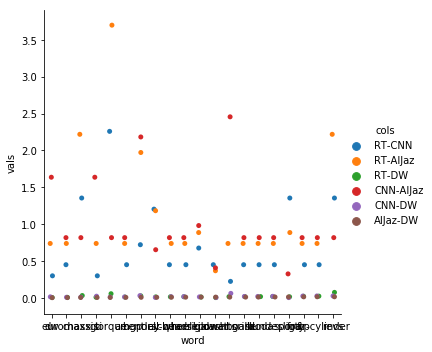

In [209]:
import seaborn as sns
top20wordAlJazDW = top20wordAlJazDW.melt('word', var_name='cols',  value_name='vals')
g = sns.catplot(x="word", y="vals", hue='cols', data=top20wordAlJazDW)